## Augmentation을 활용한 모델 성능 향상

### 학습 목표
- Augmentation을 모델 학습에 적용하기
- Augmentation의 적용을 통한 학습 효과 확인하기
- 최신 data augmentation 기법 구현 및 활용하기

### 루브릭 
- CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? : **CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.**
- 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? : **Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함**
- 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? : **기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.**


## 목차
### 0. 환경 설정
### 1. Augmentation을 적용한 데이터셋 만들기
#### 1) 데이터 로드
#### 2) Cutmix Augmentation
#### 3) Mixup Augmentation
#### 4) 데이터셋 만들기
### 2. 모델 성능 비교
#### 1) 모델 구성 및 훈련
#### 2) 각 데이터셋에 대한 결과 비교
---

### 0. 환경 설정

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Mounted at /content/gdrive


In [2]:
import os
from pathlib import Path

folder = 'Colab Notebooks'
project_dir = 'going_deeper_CV'

base_path = Path('/content/gdrive/My Drive')
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
  if x.is_dir():
    dir_name = str(x.relative_to(project_path))
    os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f'현재 디렉토리 위치: {os.getcwd()}')

현재 디렉토리 위치: /content/gdrive/My Drive/Colab Notebooks/going_deeper_CV


In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. Augmentation을 이용한 데이터셋 만들기

#### 1) 데이터 로드 및 정규화

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs', 
    split = ['train','test'],
    as_supervised=True,
    shuffle_files=True, 
    with_info=True, 
    data_dir=os.getcwd()+'/datasets'
    )

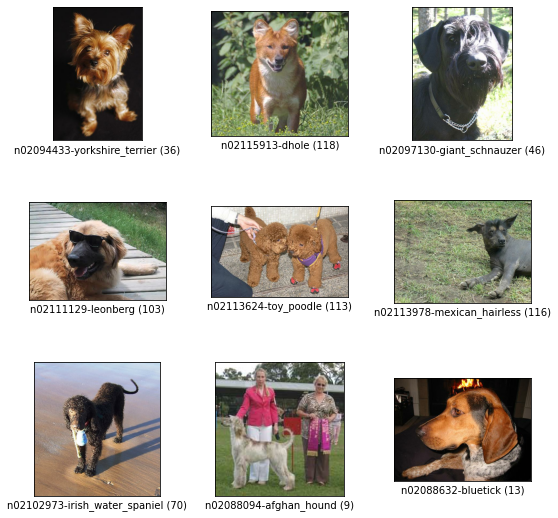

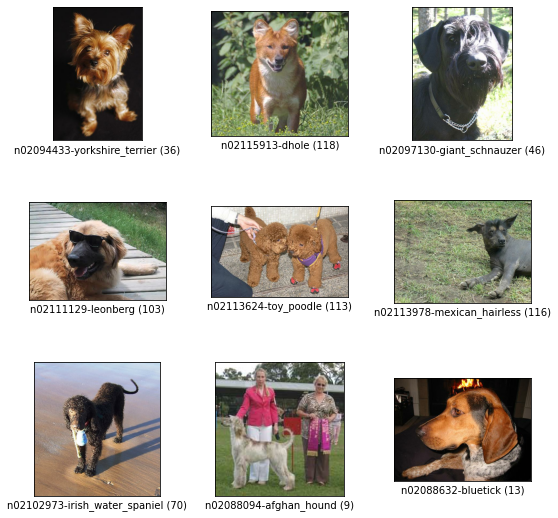

In [6]:
tfds.show_examples(ds_train, ds_info)

In [7]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

In [8]:
num_classes = ds_info.features["label"].num_classes

In [9]:
def normalize_and_resize_img(image, label):
  image = tf.image.resize(image, [224,224])
  return tf.cast(image, tf.float32) / 255., label    # float 형태이므로 int인 255로 나누면 오류가 발생한다.

* `tf.cast(tensor, dtype)`: 텐서를 새로운 자료형`dtype`으로 변환

In [10]:
def apply_normalize_on_dataset(ds, batch_size=32, is_test=False):
  ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
  )

  ds = ds.batch(batch_size)
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

  return ds

In [11]:
ds_train = apply_normalize_on_dataset(ds_train, is_test=False)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

#### 2) Cutmix Augmentation
이미지를 잘라 붙여 새 이미지를 만들고, 섞은 이미지의 비율에 맞추어 라벨도 함께 섞어 붙이는 방법

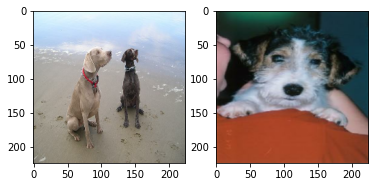

In [12]:
for i, (image, label) in enumerate(ds_train.take(1)):
  if i == 0:
    image_a = image[0]
    image_b = image[1]
    label_a = label[0]
    label_b = label[1]
    break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

1. 첫 번째 이미지 a를 바탕으로, 두 번째 이미지 b를 삽입할 이미지로 가정하고, a에 삽입될 영역의 바운딩 박스 위치를 결정하는 함수 선언

In [13]:
def get_clip_box(image_a, image_b):
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]

  # [0,image_size_x), [0, image_size_y) 범위에서 임의의 정수값을 x,y에 저장
  x = tf.cast(tf.random.uniform([],0,image_size_x), tf.int32)
  y = tf.cast(tf.random.uniform([],0,image_size_y), tf.int32)

  # image_size_x, image_size_y보다 적은 정수값 width, height에 저장 
  width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
  height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)

  # (x,y)를 중심으로 width, height를 갖는 clip box의 네 꼭지점 선언(image_b가 들어갈 공간)
  x_min = tf.math.maximum(0, x-width//2)
  y_min = tf.math.maximum(0, y-height//2)
  x_max = tf.math.minimum(image_size_x, x+width//2)
  y_max = tf.math.minimum(image_size_y, y+width//2)

  return x_min, y_min, x_max, y_max

In [14]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x: ', x_min, x_max)
print('y: ', y_min, y_max)

x:  tf.Tensor(167, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y:  tf.Tensor(10, shape=(), dtype=int32) tf.Tensor(102, shape=(), dtype=int32)


2. image_a에서 clip box의 바깥쪽, image_b에서 clip box의 안쪽 영역을 가져와서 합치는 함수 선언

In [15]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]
  middle_left = image_a[y_min:y_max, 0:x_min, :]
  middle_center = image_b[y_min:y_max, x_min:x_max, :]
  middle_right = image_a[y_min:y_max, x_max:image_size_x, :]
  middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
  top = image_a[0:y_min,:,:]
  bottom = image_a[y_max:image_size_y,:,:]
  mixed_img = tf.concat([top, middle, bottom], axis = 0)

  return mixed_img

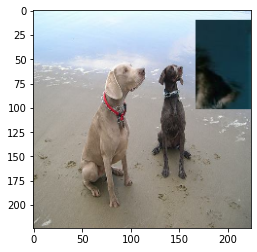

In [16]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

3. 면적에 비례해서 라벨을 섞는 함수 선언

In [17]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes):
  image_size_x = image_a.shape[1]
  image_size_y = image_b.shape[0]

  mixed_area = (x_max-x_min)*(y_max-y_min)
  total_area = image_size_x*image_size_y

  ratio = tf.cast(mixed_area/total_area, tf.float32)

  if len(label_a.shape)==0:
    label_a = tf.one_hot(label_a, num_classes)
  if len(label_b.shape)==0:
    label_b = tf.one_hot(label_b, num_classes)
  mixed_label = (1-ratio)*label_a + ratio*label_b

  return mixed_label

In [18]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.8954879 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10451212, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

4. 임의의 숫자를 받아 이미지를 섞고, 라벨을 섞는 함수 구현

In [19]:
def cutmix(image, label, batch_size=32, img_size=224, num_classes=120):
  mixed_imgs = []
  mixed_labels = []

  for i in range(batch_size):
    image_a = image[i]
    label_a = label[i]

    j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)    # 임의의 image_b 선정
    image_b = image[j]
    label_b = label[j]

    x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
    mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
    mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

  mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size,img_size, img_size, 3))
  mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size,num_classes))

  return mixed_imgs, mixed_labels

#### 3) Mixup Augmentation
픽셀 단위로 이미지를 섞어 이미지를 만들고, 섞은 이미지의 비율에 맞추어 라벨도 함께 섞어 붙이는 방법

In [20]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

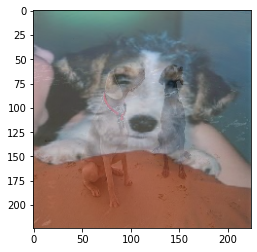

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.38394356 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.61605644 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [21]:
mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [22]:
def mixup(image, label, batch_size=32, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [23]:
def onehot(img, label):
    return img, tf.one_hot(label, num_classes)

#### 4) 데이터셋 만들기

In [24]:
# 기본 augment 기법
def augment(image,label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.clip_by_value(image,0,1)
  return image, label

In [25]:
def apply_normalize_and_augment_on_dataset(ds, is_test=False, batch_size=32, with_aug=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)

    if with_aug:
        ds = ds.map(augment)
    ds = ds.batch(batch_size)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [26]:
def apply_normalize_and_mix_on_dataset(ds, is_test=False, batch_size=32, with_aug=False, with_cutmix=False, with_mixup=False,):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    if is_test:
        with_aug = False
        with_cutmix = False
        with_mixup = False

    if with_aug:
        ds = ds.map(augment)
    ds = ds.batch(batch_size)

    if with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [27]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs', 
    split = ['train','test'],
    as_supervised=True,
    shuffle_files=True, 
    with_info=True, 
    data_dir=os.getcwd()+'/datasets'
    )

ds_train_cutmix = apply_normalize_and_mix_on_dataset(ds_train, is_test=False, with_aug = True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_normalize_and_mix_on_dataset(ds_train, is_test=False, with_aug = True, with_cutmix=False, with_mixup=True)
ds_test_mix = apply_normalize_and_mix_on_dataset(ds_test, is_test=True, with_aug = False, with_cutmix=True, with_mixup=False)

ds_train_aug = apply_normalize_and_augment_on_dataset(ds_train, is_test=False, with_aug = True)
ds_train = apply_normalize_and_augment_on_dataset(ds_train, is_test=False, with_aug = False)
ds_test = apply_normalize_and_augment_on_dataset(ds_test, is_test=True, with_aug = False)

- `ds_train_cutmix`: cutmix를 적용한 train set
- `ds_train_mixup`: mixup을 적용한 train set
- `ds_test_mix`:onehot을 적용해 위의 train set들과 shape를 맞춘 test set    


- `ds_train_aug`: 기본 augment를 적용한 train set
- `ds_train`: augment를 적용하지 않은 train set
- `ds_test`: 정규화 외 가공을 거치지 않은 test set

In [28]:
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [30]:
ds_train_aug

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [31]:
ds_test_mix

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [32]:
ds_train_cutmix

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 120), dtype=tf.float32, name=None))>

In [33]:
ds_train_mixup

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 120), dtype=tf.float32, name=None))>

### 2. 모델 성능 비교

#### 1) 모델 구성 및 훈련
keras에서 imagenet으로 미리 훈련된 모델(ResNet50)을 불러오되, 사용할 데이터셋이 imagenet과 다른 클래스를 가지므로, 마지막 fully connected layer는 불러오지 않고 추후에 수정된 fully connected layer를 붙인다. 즉, 훈련된 ResNet50을 불러오되 '특성 추출' 부분만 가지고 오는 셈이다.    
augmentation을 적용한 데이터셋으로 학습시킬 모델과 그렇지 않은 모델 두 가지를 만든다.

In [34]:
resnet50 = keras.models.Sequential([
                                    keras.applications.resnet.ResNet50(
                                        include_top = False,    # fully connected layer 부르지 않음
                                        weights = 'imagenet',
                                        input_shape = (224,224,3),    # 전처리 완료한 shape
                                        pooling = 'avg'
                                        ),
                                    keras.layers.Dense(num_classes, activation = 'softmax')    # 사용할 데이터셋에 맞는 fully connected layer 추가
])

94781440/94765736 [==============================] - 1s 0us/step


In [35]:
aug_resnet50 = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top = False,
                                            weights = 'imagenet',
                                            input_shape = (224,224,3),
                                            pooling = 'avg'
                                            ),
                                        keras.layers.Dense(num_classes, activation = 'softmax')
])

In [36]:
cutmix_resnet50 = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top = False,
                                            weights = 'imagenet',
                                            input_shape = (224,224,3),
                                            pooling = 'avg'
                                            ),
                                        keras.layers.Dense(num_classes, activation = 'softmax')
])

In [37]:
mixup_resnet50  = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top = False,
                                            weights = 'imagenet',
                                            input_shape = (224,224,3),
                                            pooling = 'avg'
                                            ),
                                        keras.layers.Dense(num_classes, activation = 'softmax')
])

In [38]:
EPOCH = 20

In [39]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [40]:
history_resnet50_no_aug = resnet50.fit(
    ds_train, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
375/375 [==============================] - 99s 218ms/step - loss: 2.4887 - accuracy: 0.4291 - val_loss: 5.0474 - val_accuracy: 0.0113
Epoch 2/20
375/375 [==============================] - 74s 197ms/step - loss: 0.8461 - accuracy: 0.7760 - val_loss: 3.0245 - val_accuracy: 0.2687
Epoch 3/20
375/375 [==============================] - 74s 197ms/step - loss: 0.4080 - accuracy: 0.9081 - val_loss: 1.0562 - val_accuracy: 0.6852
Epoch 4/20
375/375 [==============================] - 74s 197ms/step - loss: 0.1934 - accuracy: 0.9678 - val_loss: 0.9447 - val_accuracy: 0.7205
Epoch 5/20
375/375 [==============================] - 74s 197ms/step - loss: 0.1034 - accuracy: 0.9896 - val_loss: 0.9450 - val_accuracy: 0.7255
Epoch 6/20
375/375 [==============================] - 74s 197ms/step - loss: 0.0651 - accuracy: 0.9960 - val_loss: 0.9219 - val_accuracy: 0.7348
Epoch 7/20
375/375 [==============================] - 74s 197ms/step - loss: 0.0400 - accuracy: 0.9975 - val_loss: 0.9501 - val_ac

In [41]:
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [42]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
375/375 [==============================] - 83s 198ms/step - loss: 2.5757 - accuracy: 0.4058 - val_loss: 5.1297 - val_accuracy: 0.0068
Epoch 2/20
375/375 [==============================] - 73s 196ms/step - loss: 1.0176 - accuracy: 0.7203 - val_loss: 2.7069 - val_accuracy: 0.3141
Epoch 3/20
375/375 [==============================] - 73s 196ms/step - loss: 0.6468 - accuracy: 0.8263 - val_loss: 1.0018 - val_accuracy: 0.7056
Epoch 4/20
375/375 [==============================] - 73s 196ms/step - loss: 0.4136 - accuracy: 0.8959 - val_loss: 1.0448 - val_accuracy: 0.6952
Epoch 5/20
375/375 [==============================] - 74s 197ms/step - loss: 0.2699 - accuracy: 0.9403 - val_loss: 0.9332 - val_accuracy: 0.7241
Epoch 6/20
375/375 [==============================] - 74s 198ms/step - loss: 0.1859 - accuracy: 0.9622 - val_loss: 0.9115 - val_accuracy: 0.7325
Epoch 7/20
375/375 [==============================] - 74s 197ms/step - loss: 0.1253 - accuracy: 0.9794 - val_loss: 0.9497 - val_ac

In [43]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [44]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test_mix,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
375/375 [==============================] - 87s 204ms/step - loss: 4.1790 - accuracy: 0.1472 - val_loss: 5.3342 - val_accuracy: 0.0078
Epoch 2/20
375/375 [==============================] - 75s 201ms/step - loss: 3.1762 - accuracy: 0.3686 - val_loss: 2.7518 - val_accuracy: 0.3101
Epoch 3/20
375/375 [==============================] - 82s 219ms/step - loss: 2.8638 - accuracy: 0.4591 - val_loss: 1.2901 - val_accuracy: 0.6502
Epoch 4/20
375/375 [==============================] - 76s 203ms/step - loss: 2.6932 - accuracy: 0.5107 - val_loss: 1.2242 - val_accuracy: 0.6702
Epoch 5/20
375/375 [==============================] - 77s 204ms/step - loss: 2.5680 - accuracy: 0.5492 - val_loss: 1.2970 - val_accuracy: 0.6449
Epoch 6/20
375/375 [==============================] - 76s 203ms/step - loss: 2.4679 - accuracy: 0.5753 - val_loss: 1.1752 - val_accuracy: 0.6789
Epoch 7/20
375/375 [==============================] - 76s 202ms/step - loss: 2.3824 - accuracy: 0.5983 - val_loss: 1.1961 - val_ac

In [45]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [46]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/32),
    validation_steps=int(ds_info.splits['test'].num_examples/32),
    epochs=EPOCH,
    validation_data=ds_test_mix,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
375/375 [==============================] - 86s 204ms/step - loss: 3.9469 - accuracy: 0.1992 - val_loss: 5.3047 - val_accuracy: 0.0075
Epoch 2/20
375/375 [==============================] - 75s 201ms/step - loss: 2.9725 - accuracy: 0.4508 - val_loss: 3.4532 - val_accuracy: 0.2057
Epoch 3/20
375/375 [==============================] - 76s 202ms/step - loss: 2.7092 - accuracy: 0.5457 - val_loss: 1.6154 - val_accuracy: 0.5695
Epoch 4/20
375/375 [==============================] - 83s 221ms/step - loss: 2.5657 - accuracy: 0.5872 - val_loss: 1.1923 - val_accuracy: 0.6639
Epoch 5/20
375/375 [==============================] - 77s 206ms/step - loss: 2.4729 - accuracy: 0.6239 - val_loss: 1.4908 - val_accuracy: 0.5859
Epoch 6/20
375/375 [==============================] - 77s 205ms/step - loss: 2.3767 - accuracy: 0.6647 - val_loss: 1.1095 - val_accuracy: 0.6868
Epoch 7/20
375/375 [==============================] - 76s 204ms/step - loss: 2.3121 - accuracy: 0.6885 - val_loss: 1.2072 - val_ac

#### 2) 각 데이터셋에 대한 결과 비교

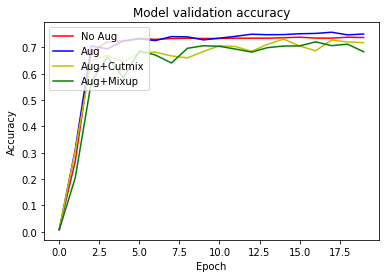

In [49]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'y')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug', 'Aug+Cutmix', 'Aug+Mixup'], loc='upper left')
plt.show()

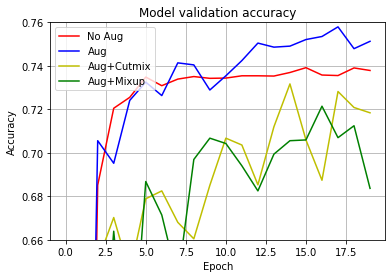

In [51]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'y')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'Aug', 'Aug+Cutmix', 'Aug+Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.66, 0.76)
plt.show()

* 예상과는 달리 cutmix나 mixup을 한 경우 오히려 augmentation을 사용하지 않은 경우보다 validation accuracy가 떨어졌다. 위에서 구한 예시 이미지에 의하면 엉뚱한 합성 사진이 나오거나(cutmix), 원래 이미지보다도 알아보기 어려운 사진이 나올 때가 있어(mixup) 이런 이미지들이 데이터셋의 품질을 오히려 저하시키고 있는 것이 아닌지 추측된다.
* cutmix를 수행할 때, 예를 들어 개와 고양이의 사진을 섞어 만든 사진일 때 '개의 특징'이 되는 부분과 '고양이의 특징'이 되는 부분이 적절히 섞여 두 이미지를 일부씩 학습하는 셈이 된다면 효과를 볼 수도 있겠지만, 지금은 임의의 공간을 잘라내 붙이는 방식이고, 또 각 label별의 특징이 무엇인지 규정하기 곤란하기 때문에, 예시 이미지처럼 공백이 섞이는 등의 사진이 나타나는 것은 피할 수 없을 것이다. 확률적으로 사진이 뒤섞이는 것을 고려하면, epoch를 더 크게 해 유의미한 mix 사진을 더 확보할 수 있도록 하면 논문에서처럼 효과를 볼 수 있지 않을까.
* 최종 validation accuracy는 다음과 같다.
  * No Arg: 0.7379 | Arg: 0.7513(1.8% 향상) | Cutmix: 0.7184(2.6% 하락) | Mixup: 0.6837(7.3% 하락)

## 회고
- RAM 사용량이 다 되어 세션이 종료되는 경우가 많았다.... '고용량 RAM'을 사용하도록 런타임 유형을 변경하고 batch_size를 32로 늘려 해결하긴 했지만 이것이 효율적인지, 맞는 방법인지는 의문이 남는다.
- Tensor의 shape를 맞추어 Pipeline을 구성하는 일련의 과정을 이해하기 도무지 어렵다. 특히 `ds.prefetch(tf.data.experimental.AUTOTUNE)`이 도대체 무슨 뜻인지 아무리 검색을 해봐도 모르겠다.. tensorflow 공부를 따로 해두면 도움이 좀 될까. `ds_test_mix`, `ds_train_cutmix`, `ds_train_mixup`의 shape가 완전히 같아야 하는 줄 알고 많이 헤맸다.
- imgae data augmentation은 문자 그대로 데이터의 양을 증강시켜 train에 보탬을 주는 방법이라고 생각했었다. 원래 train에 들어있는 이미지 샘플 수는 12000개였는데, 각 augmentation을 통해서는 몇개의 샘플을 학습한 것과 같은 효과인지 알 수 있는 방법이 있을까 의문이 들었는데, 이번 프로젝트에서 살펴 본 바로는 **이미지 샘플 수, 즉 양 자체가 늘어난다기보다 하나의 이미지를 학습하면서도 다양한 정보, 다양한 경우를 학습할 수 있도록 가공하는 방법**이라고 보는 것이 더 맞는 것 같다. 대칭, 밝기조절과 같은 노이즈 발생 상황을 함께 학습하는 것 기본 augment라면, 한 이미지에서 두가지 이미지를 학습하는 효과를 얻는 것이 cutmix나 mixup이다.
- 생각보다 기본 augmentation만 적용하더라도 성능 향상에 도움이 되는 것을 확인할 수 있었다. 5% 향상까지 노리기 위해서는 `flip_up_down`이나 `central_crop` 등을 추가로 시도해봐야 할 것 같다.